Kalman Filter
（参考）https://ashikapengin.com/2021/10/20/kalman01/

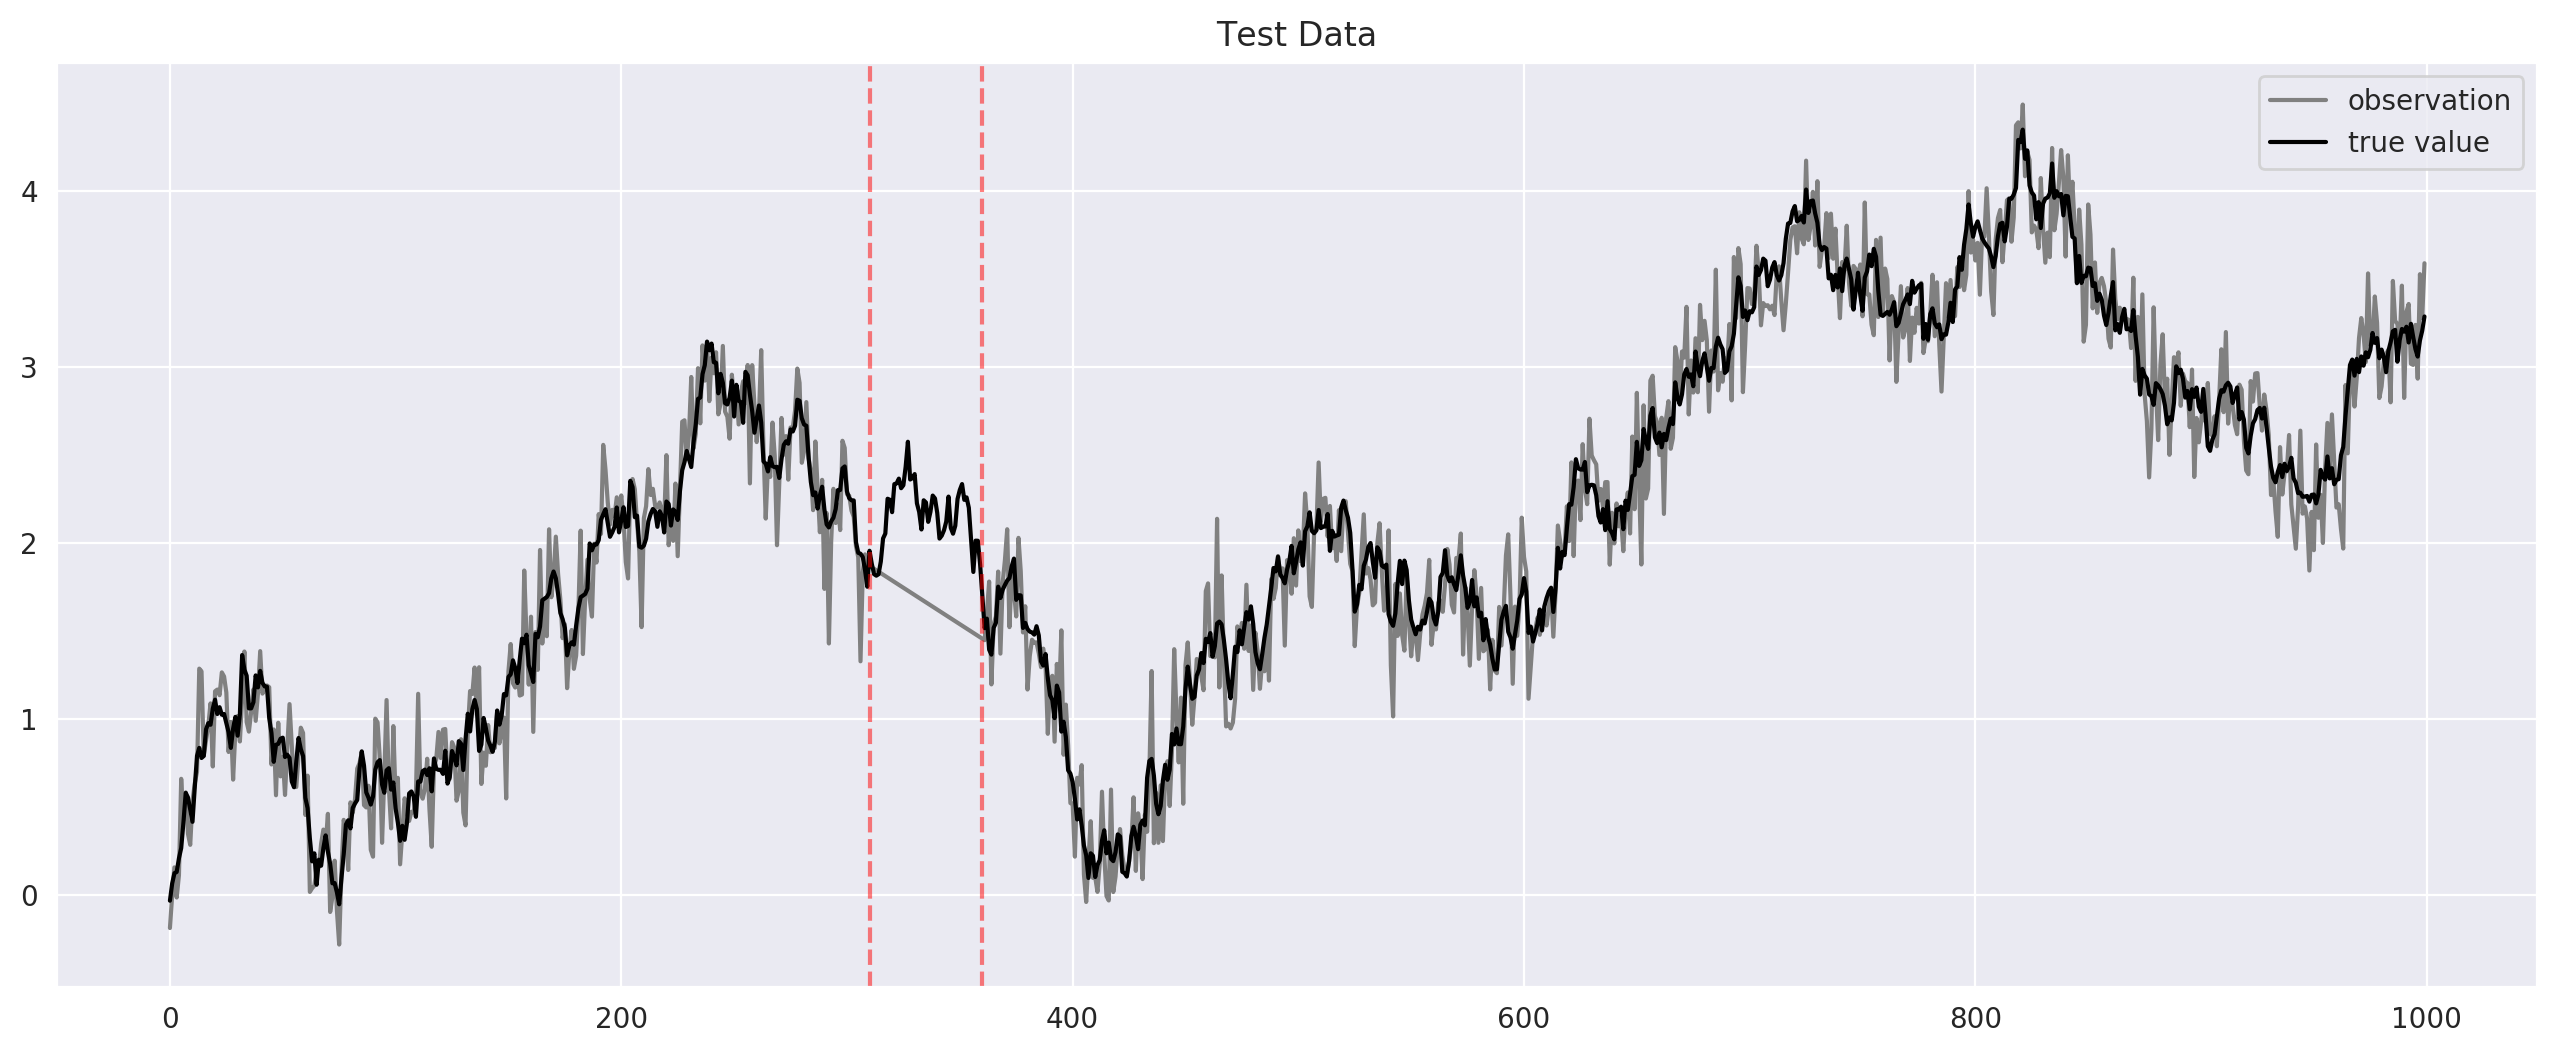

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize
sns.set_style('darkgrid')

G = np.array([[1,0],[0,0]])       # システムモデルの係数行列（1次のトレンドモデル）
#G = np.array([[2,-1],[1,0]])       # システムモデルの係数行列（2次のトレンドモデル）
F = np.array([[1,0]])              # 観測モデルの係数行列
T = 1000                           #最大時間
x0 = 0                             #初期値
Tr = 0                             #尤度算出のためのトリガー(Tr=1で尤度算出用)
np.random.seed(seed=32)            #ランダムシード固定
w = np.random.normal(0, 0.1, T)    #システムノイズ(標準偏差0.1)
v = np.random.normal(0, 0.2, T)    #観測ノイズ(標準偏差0.2)
x = np.zeros(T)                    #状態変数の初期化
y = np.full(T,np.nan)              #観測値の初期化

# 状態変数と観測値の作成(t=310～360では観測値は得られなかったと仮定)
x[0] = x0 + w[0]
y[0] = x[0] + v[0]
for t in range(1, T):
    x[t] = x[t-1] + w[t]
    if t < 310 or 360 < t:
        y[t] = x[t] + v[t]

# 作成したデータの確認と保存
fig, axes = plt.subplots(nrows=1, figsize=(16, 6))
plt.title("Test Data")
sns.lineplot(x=np.arange(T), y=y, color="gray", label="observation")
sns.lineplot(x=np.arange(T), y=x, color="black", label="true value")
axes.axvline(310, color="red", linestyle="--", alpha=0.5)
axes.axvline(360, color="red", linestyle="--", alpha=0.5)
plt.show()
plt.show()
fig.savefig("data.png", transparent = True, bbox_inches = 'tight', pad_inches = 0)

In [3]:
def kalman_prediction(a, R, W, G=G):
    """
    Kalman prediction
    """
    a = G @ a
    R = G @ R @ G.T + W
    return a, R

def kalman_filter(m, C, y, W, V, F=F, G=G, Tr=Tr):
    """
    Kalman Filter
    m: 時点t-1のフィルタリング分布の平均
    C: 時点t-1のフィルタリング分布の分散共分散行列
    y: 時点tの観測値
    """
    a = G @ m
    R = G @ C @ G.T + W
    f = F @ a
    Q = F @ R @ F.T + V
    K = (np.linalg.solve(Q.T, F @ R.T)).T
    m = a + K @ (y - f)
    C = R - K @ F @ R
    L = np.log(np.linalg.det(Q)) + ((y - f).T)@(np.linalg.inv(Q))@(y - f) #尤度計算のため追加
    if Tr == 1: # 尤度計算のとき
        return m, C, L.flatten()
    else: # フィルタのみ実行するとき
        return m, C

def kalman_smoothing(s, S, m, C,  W, G=G):
    """
    Kalman smoothing
    """
    # 1時点先予測分布のパラメータ計算
    a = G @ m
    R = G @ C @ G.T + W
    # 平滑化利得の計算
    A = C @ G.T @ np.linalg.pinv(R)
    # 状態の更新
    s = m + A @ (s - a)
    S = C + A @ (S - R) @ A.T
    return s, S